In [16]:
import psycopg2
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

#### Connecting to database 

In [17]:
conn = psycopg2.connect(
    host = '165.22.22.202' ,
    database = 'gsmarena' ,
    user = 'anomaly' ,
    password = 'Hitman.agent47'    
)

### PRICE ~ BRAND ~ DISPLAYSIZE

#### Fetching required tables from database 

In [18]:
cur = conn.cursor()
cur.execute(''' SELECT "BrandName" , "Price", "DisplaySize"
                FROM devices
                WHERE "BrandName" IN ('Apple118', 'Xiaomi377' , 'Samsung1383' ) ;''')

rows = cur.fetchall()
col_names = [desc[0] for desc in cur.description]

price_display = pd.DataFrame(rows, columns=col_names)

In [19]:
price_display

,BrandName,Price,DisplaySize
0,Xiaomi377,999,6.55
1,Xiaomi377,49,6.67
2,Xiaomi377,999,6.67
3,Xiaomi377,990,6.67
4,Xiaomi377,0,6.28
...,...,...,...
4784,Apple118,230 EUR,4.70
4785,Apple118,240 EUR,5.50
4786,Apple118,180 EUR,4.70
4787,Apple118,320 EUR,5.50


In [20]:
price_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4789 entries, 0 to 4788
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BrandName    4789 non-null   object 
 1   Price        4789 non-null   object 
 2   DisplaySize  4789 non-null   float64
dtypes: float64(1), object(2)
memory usage: 112.4+ KB


#### Convert Price from object into int 

In [21]:
prices = [] 
for price in price_display['Price'] :
    prices.append(price.split(' ')[0])

price_display['Price'] = prices
price_display['Price'] = price_display['Price'].astype('int')

In [22]:
price_display.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4789 entries, 0 to 4788
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BrandName    4789 non-null   object 
 1   Price        4789 non-null   int64  
 2   DisplaySize  4789 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 112.4+ KB


#### Display Class

In [23]:
def display_class(x) :
    if x >= 7 :
        return 'LARGE'
    return 'SMALL'

In [24]:
price_display['DisplayClass'] = price_display['DisplaySize'].apply(display_class)

#### Checking for normalization 

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

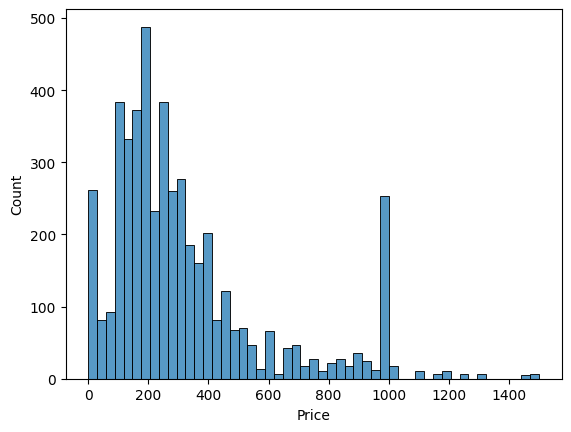

In [25]:
sns.histplot(price_display['Price'])

In [26]:
from scipy.stats import normaltest , levene

In [27]:
stat_dagostino, p_value_dagostino = normaltest(price_display['Price'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=1245.0927998982695, p-value=4.280887090494241e-271


#### Make price Normal

In [28]:
from scipy.stats import yeojohnson , boxcox 

In [29]:
price_display['Normal_Price'] = yeojohnson(price_display['Price'])[0]

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Normal_Price', ylabel='Count'>

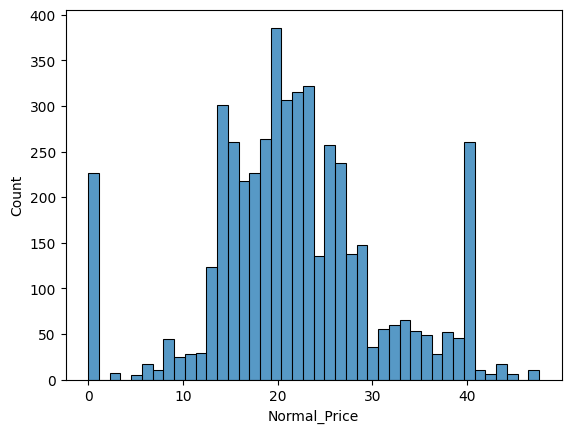

In [30]:
sns.histplot(price_display['Normal_Price'])

In [31]:
stat_dagostino, p_value_dagostino = normaltest(price_display['Normal_Price'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=38.18213332661356, p-value=5.115111376429921e-09


In [33]:
price_display['Normal_Price'] = boxcox(price_display['Price'] + 1)[0]

/Applications/anaconda3/envs/quera/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Normal_Price', ylabel='Count'>

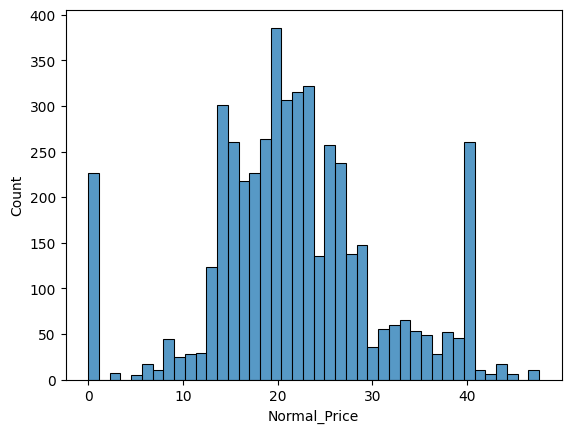

In [34]:
sns.histplot(price_display['Normal_Price'])

In [35]:
stat_dagostino, p_value_dagostino = normaltest(price_display['Normal_Price'])
print(f"D'Agostino-Pearson Test of : Statistics={stat_dagostino}, p-value={p_value_dagostino}")

D'Agostino-Pearson Test of : Statistics=38.18213541716821, p-value=5.115106029722769e-09


We cant make price normal so we use anova testing two way 

#### ANOVA

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

One-way ANOVA results:
                    sum_sq      df          F        PR(>F)
brand         1.448928e+06     2.0  10.339790  3.304959e-05
classs        5.158078e+06     1.0  73.617776  1.264482e-17
brand:classs  1.292347e+06     2.0   9.222401  1.005692e-04
Residual      3.351241e+08  4783.0        NaN           NaN


<Axes: xlabel='brand', ylabel='price'>

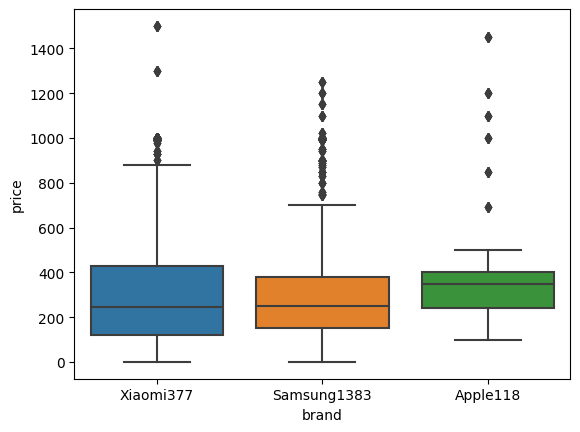

In [38]:
OTANOVA ={"price": price_display['Price'], "brand" : price_display['BrandName'], "classs": price_display['DisplayClass']}
OTANOVA =  pd.DataFrame(OTANOVA)
model = ols('price ~ brand * classs', data=OTANOVA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("One-way ANOVA results:")
print(anova_table)
sns.boxplot(x='brand', y='price', data=OTANOVA)

One-way ANOVA results:
                     sum_sq      df           F        PR(>F)
brand            818.423348     2.0    5.146159  5.854000e-03
classs          9675.794758     1.0  121.680740  5.876694e-28
brand:classs     494.512543     2.0    3.109442  4.471606e-02
Residual      380334.031500  4783.0         NaN           NaN


<Axes: xlabel='brand', ylabel='price'>

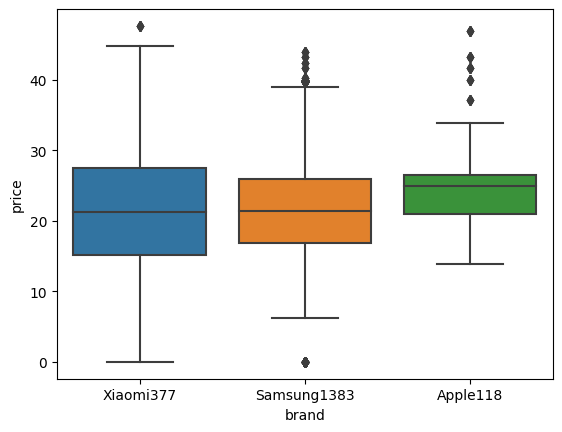

In [39]:
OTANOVA ={"price": price_display['Normal_Price'], "brand" : price_display['BrandName'], "classs": price_display['DisplayClass']}
OTANOVA =  pd.DataFrame(OTANOVA)
model = ols('price ~ brand * classs', data=OTANOVA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("One-way ANOVA results:")
print(anova_table)
sns.boxplot(x='brand', y='price', data=OTANOVA)

In [40]:
from scipy.stats import mannwhitneyu

In [41]:
small_display = price_display[price_display['DisplayClass'] == 'SMALL']['Price']
big_display = price_display[price_display['DisplayClass'] == 'LARGE']['Price']

In [42]:
u_statistic, p_value = mannwhitneyu(small_display, big_display )
p_value

9.100583404710398e-47

In [43]:
u_statistic, p_value = mannwhitneyu(small_display, big_display , alternative='greater')
p_value

1.0

In [44]:
u_statistic, p_value = mannwhitneyu( big_display , small_display, alternative='greater')
p_value

4.550291702355199e-47